In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [2]:
df = pd.read_csv("auto-mpg.csv")

In [3]:
# Convert origin to one-hot encoding
origin = df.pop("origin")
df["USA"] = (origin == 1).astype(float)
df["Europe"] = (origin == 2).astype(float)
df["Japan"] = (origin == 3).astype(float)

In [4]:
df = df.dropna()

In [5]:
# Check for non-numerical columns
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
print("Non-numerical columns:", non_numeric_columns)

Non-numerical columns: Index(['horsepower', 'car name'], dtype='object')


In [6]:
# Convert non-numerical columns to numerical
for column in non_numeric_columns:
    df[column] = pd.Categorical(df[column]).codes

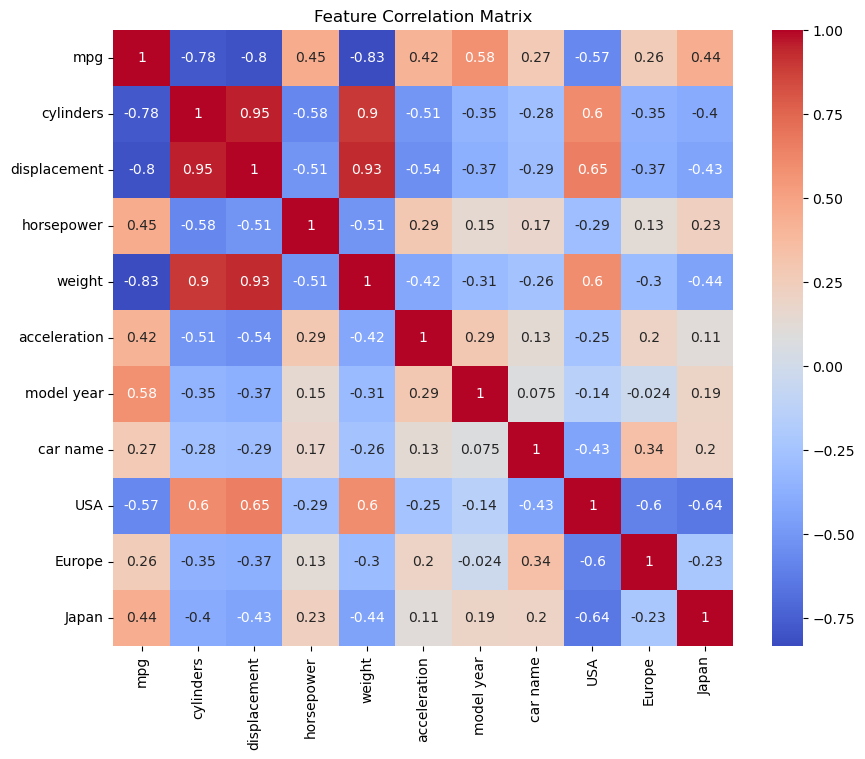

In [7]:
# Analyze correlation
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [8]:
# Drop highly correlated features (threshold > 0.85)
# Example: 'weight' and 'displacement' are highly correlated
df = df.drop(['displacement'], axis=1)

In [9]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
# Separate labels
train_labels = train_data.pop("mpg")
test_labels = test_data.pop("mpg")

In [11]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [12]:
# Define the model architecture
def build_model():
    model = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=[train_data.shape[1]]),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
                    loss='mse',
                    metrics=['mae', 'mse'])
    return model

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Train the model with early stopping
model = build_model()
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(train_data, train_labels,
                      epochs=1000,
                      validation_split=0.2,
                      verbose=0,
                      callbacks=[early_stop])

In [15]:
# Evaluate the model
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=0)
print(f"Testing set Mean Absolute Error: {mae:.2f} MPG")


Testing set Mean Absolute Error: 1.64 MPG


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


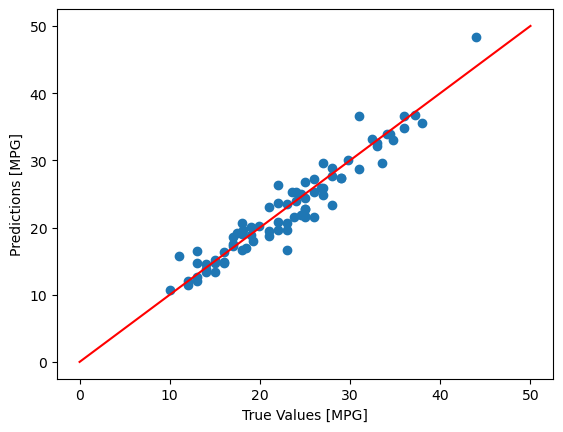

In [16]:
# Predictions
test_predictions = model.predict(test_data).flatten()
plt.scatter(test_labels, test_predictions)
plt.plot([0, 50], [0, 50], color='red')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.show()

In [17]:
mae = mean_absolute_error(test_labels, test_predictions)
mse = mean_squared_error(test_labels, test_predictions)
r2 = r2_score(test_labels, test_predictions)
print("Mean Absolute Error (MAE):",mae)
print("Mean Squared Error (MSE):",mse)
print("R-squared (R²):",r2)


Mean Absolute Error (MAE): 1.6415040254592896
Mean Squared Error (MSE): 4.561245847454409
R-squared (R²): 0.9151655655586407
